In [1]:
import ktrain
from ktrain import text
import pandas as pd
import random
import numpy as np
import math

In [2]:
csv_file = '../../data/merged_ktrain_google_en.csv'
data = pd.read_csv(csv_file).values
print(len(data))

21589


In [3]:
epochs = 3
learning_rate = 5e-5
batch_size = 32
max_length = 21
max_words = 25000

In [4]:
def split_test_data(data, split=0.1, random_seed=42):
    np.random.seed(random_seed)
    np.random.shuffle(data)
    split_item = math.floor(split * len(data))
    print('split at: ', split_item)
    x_test, y_test = data[:split_item, 0], data[:split_item, 1:]
    x_train, y_train = data[split_item:, 0], data[split_item:, 1:]
    return x_train, y_train, x_test, y_test

In [17]:
x_train, y_train, x_val, y_val = split_test_data(data, split=0.05, random_seed=4242)
print(len(x_train), len(y_train), len(x_val), len(y_val))

split at:  1079
20510 20510 1079 1079


In [18]:
MODEL = 'distilbert-base-uncased'
transformer = text.Transformer(MODEL, maxlen=max_length, class_names=['less', 'equal', 'more'])
train_data = transformer.preprocess_train(x_train, y_train)
val_data = transformer.preprocess_test(x_val, y_val)

preprocessing train...
language: en
train sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 18


Is Multi-Label? False
preprocessing test...
language: en
test sequence lengths:
	mean : 9
	95percentile : 15
	99percentile : 18


In [19]:
model = transformer.get_classifier()

In [20]:
learner = ktrain.get_learner(model, train_data=train_data, val_data=val_data, batch_size=batch_size)

simulating training for different learning rates... this may take a few moments...
Train for 640 steps
Epoch 1/2
640/640 [==============================] - 52s 81ms/step - loss: 0.9287 - accuracy: 0.6507
Epoch 2/2
480/640 [=====================>........] - ETA: 11s - loss: 1.9869 - accuracy: 0.6544

done.
Visually inspect loss plot and select learning rate associated with falling loss


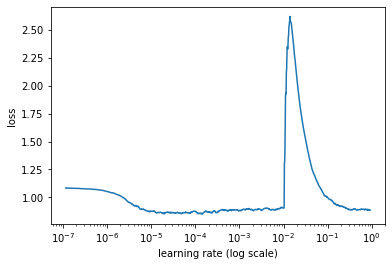

In [21]:
learner.lr_find(show_plot=True, max_epochs=2)

In [22]:
learner.fit_onecycle(5e-5, epochs=3)



begin training using onecycle policy with max lr of 5e-05...
Train for 641 steps, validate for 34 steps
Epoch 1/3
641/641 [==============================] - 54s 84ms/step - loss: 0.8707 - accuracy: 0.6688 - val_loss: 0.8950 - val_accuracy: 0.6460
Epoch 2/3
641/641 [==============================] - 48s 74ms/step - loss: 0.8517 - accuracy: 0.6709 - val_loss: 0.9038 - val_accuracy: 0.6497
Epoch 3/3
641/641 [==============================] - 48s 74ms/step - loss: 0.7164 - accuracy: 0.7082 - val_loss: 0.9905 - val_accuracy: 0.5978


In [13]:
learner.view_top_losses(n=10, preproc=transformer)

----------
id:986 | loss:3.74 | true:more | pred:equal)

----------
id:2047 | loss:3.62 | true:less | pred:equal)

----------
id:187 | loss:3.55 | true:more | pred:equal)

----------
id:787 | loss:3.54 | true:more | pred:equal)

----------
id:395 | loss:3.49 | true:more | pred:equal)

----------
id:175 | loss:3.49 | true:more | pred:equal)

----------
id:1166 | loss:3.45 | true:more | pred:equal)

----------
id:1634 | loss:3.44 | true:less | pred:equal)

----------
id:794 | loss:3.42 | true:more | pred:equal)

----------
id:802 | loss:3.36 | true:less | pred:equal)



In [14]:
predictor = ktrain.get_predictor(learner.model, preproc=transformer)

In [16]:
predictor.explain(x_train[2047])